```
D:\CVProject\model_repository>tree /f /a
Volume 볼륨에 대한 폴더 경로의 목록입니다.
볼륨 일련 번호는 1CED-7EFD입니다.
D:.
+---densenet_onnx
|   |   config.pbtxt
|   |   densenet_labels.txt
|   |
|   \---1
|           model.onnx
|
\---resnet50_onnx
    |   config.pbtxt
    |   resnet50_imagenet.txt
    |
    \---1
            model.onnx
```

```
D:\CVProject\model_repository>type densenet_onnx\config.pbtxt
name: "densenet_onnx"
platform: "onnxruntime_onnx"
max_batch_size : 0
input [
  {
    name: "data_0"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 224, 224 ]
    reshape { shape: [ 1, 3, 224, 224 ] }
  }
]
output [
  {
    name: "fc6_1"
    data_type: TYPE_FP32
    dims: [ 1000 ]
    reshape { shape: [ 1, 1000, 1, 1 ] }
    label_filename: "densenet_labels.txt"
  }
]
```

```
D:\CVProject\model_repository>type resnet50_onnx\config.pbtxt
name: "resnet50_onnx"
platform: "onnxruntime_onnx"
max_batch_size : 0
input [
  {
    name: "data"
    data_type: TYPE_FP32
    format: FORMAT_NCHW
    dims: [ 3, 224, 224 ]
    reshape { shape: [ 1, 3, 224, 224 ] }
  }
]
output [
  {
    name: "resnetv24_dense0_fwd"
    data_type: TYPE_FP32
    dims: [ -1, 1000 ]
    reshape { shape: [ -1, 1000 ] }
    label_filename: "resnet50_imagenet.txt"
  }
]
```

`docker run --gpus all --rm -p 8000:8000 -p 8001:8001 -p 8002:8002 -v D:\CVProject\model_repository:/models nvcr.io/nvidia/tritonserver:24.04-py3 tritonserver --model-repository=/models`

In [5]:
TRITON_URL = "https://nvidia.edens.one" # @param {type:"string"}
API_KEY = "" # @param {type: "string"}


In [2]:
import requests
import json
import cv2
import numpy as np
from PIL import Image

In [6]:
url = f'{TRITON_URL}/v2/'
headers = {"pal-ette-pass": API_KEY}

In [7]:
requests.get(f"{url}health/ready", headers=headers)

<Response [200]>

In [8]:
requests.post(f"{url}repository/index", headers=headers).json()

[{'name': 'resnet50_onnx', 'version': '1', 'state': 'READY'},
 {'name': 'skin_eye', 'version': '1', 'state': 'READY'}]

In [11]:
def build_resnet50_payload(array, classification=5):
    return json.dumps(
        {
            "inputs": [
                {
                    "name": "data",
                    "datatype": "FP32",
                    "shape": [3, 224, 224],
                    "data": array,
                }
            ],
            "outputs": [
                {"name": "resnetv24_dense0_fwd", "parameters": {"classification": classification}}
            ],
        }
    )


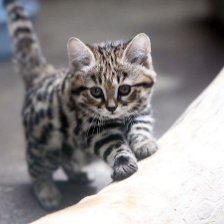

In [9]:
Image.open("cat.png")

In [14]:
# https://github.com/microsoft/onnxjs-demo/blob/master/src/components/models/Resnet50.vue
im = cv2.resize(cv2.imread("cat.png"), (224, 224)).astype(np.float32)
im[:,:,0] = ((im[:,:,0] / 255) - 0.485) / 0.229
im[:,:,1] = ((im[:,:,1] / 255) - 0.456) / 0.224
im[:,:,2] = ((im[:,:,2] / 255) - 0.406) / 0.225
im = im.transpose((2,0,1))
response = requests.post(
    f"{url}models/resnet50_onnx/infer",
    data=build_resnet50_payload(im.tolist()),
    headers=headers,
)
response_json = response.json()
response_json

{'model_name': 'resnet50_onnx',
 'model_version': '1',
 'outputs': [{'name': 'resnetv24_dense0_fwd',
   'datatype': 'BYTES',
   'shape': [5],
   'data': ['10.438505:282:tiger cat',
    '9.003094:281:tabby',
    '7.962210:292:tiger',
    '7.883459:285:Egyptian cat',
    '7.100149:288:leopard']}]}